In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [13]:
X_train = pd.read_csv("MNIST_data/bindigit_trn.csv",header=None,dtype=np.float32).as_matrix()
y_train = pd.read_csv("MNIST_data/targetdigit_trn.csv",header=None,names=["Label"],dtype=np.float32).as_matrix()

X_test = pd.read_csv("MNIST_data/bindigit_tst.csv",header=None,dtype=np.float32).as_matrix()
y_test = pd.read_csv("MNIST_data/targetdigit_tst.csv",header=None,names=["Label"],dtype=np.float32).as_matrix()

In [10]:
#Helper class for plotting images
def plotImage(images,predictions):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(predictions[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [28]:
#Class that defines the behavior of the RBM
class RBM(object):
    
    def __init__(self, input_size, output_size):
        #Defining the hyperparameters
        self._input_size = input_size #Size of input
        self._output_size = output_size #Size of output
        self.epochs = 5 #Amount of training iterations
        self.learning_rate = 1.0 #The step used in gradient descent
        self.batchsize = 100 #The size of how much data will be used for training per sub iteration
        
        #Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32) #Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32) #Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32) #Creates and initializes the visible biases with 0


    #Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        #Sigmoid 
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    #Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    #Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    #Training method for the model
    def train(self, X):
        #Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])
        
        #Previous weights and biases?
        prv_w = np.zeros([self._input_size, self._output_size], np.float32) #Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32) #Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32) #Creates and initializes the visible biases with 0

        #Current weights and biases?
        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        
        #Contrastive divergence algorithm (Steps taken from wikipedia)
        v0 = tf.placeholder("float", [None, self._input_size]) #The input vector (Step 1)
        
        #Initialize with sample probabilities (Step 3)
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb)) #Calculates hidden units given visible
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb)) #(Re-?)Calculates visible units given hidden
        h1 = self.prob_h_given_v(v1, _w, _hb) #Again calculate hidden from visible, but no sampling
        
        #Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0) #(Step 2)
        negative_grad = tf.matmul(tf.transpose(v1), h1) #(Step 4)
        
        #Update learning rates for the layers ??? (You mean weights and biases)
        update_w = _w + self.learning_rate *(positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0]) #(Step 5 with som normalization)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        #Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        #Training loop
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            #For each epoch
            for epoch in range(self.epochs):
                #For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    #Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print('Epoch: %d' % epoch,'reconstruction error: %f' % error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb

    #Create expected output for our DBN
    def rbm_outpt(self, X):
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        reconstruct = self.prob_v_given_h(out,self.w,self.vb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out),sess.run(reconstruct)
        
        
        

In [29]:
input_size = 784
output_size = 50
rbm = RBM(input_size, output_size)

rbm.train(X_train) 

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0 reconstruction error: 0.119664
Epoch: 1 reconstruction error: 0.103200
Epoch: 2 reconstruction error: 0.095437
Epoch: 3 reconstruction error: 0.091790
Epoch: 4 reconstruction error: 0.089801


In [30]:
#Return the output layer
output,reconstruct = rbm.rbm_outpt(X_train)

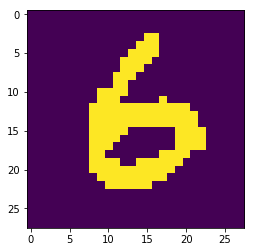

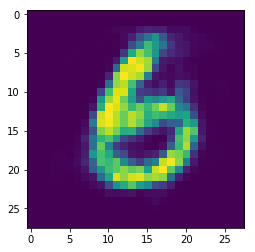

In [35]:
plt.imshow(X_train[0].reshape(28, 28))
plt.show()

plt.imshow(reconstruct[0].reshape(28, 28))
plt.show()